In [2]:
import tensorflow as tf

In [3]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [3]:
# !pip install skillsnetwork==0.20.6

In [4]:
# !pip install tensorflow_addons

In [5]:
# !pip install matplotlib==3.5.1

In [4]:
import warnings
warnings.simplefilter('ignore')

import keras
from keras.utils.vis_utils import plot_model

import numpy as np
import tensorflow as tf
print(f"tensorflow version: {tf.__version__}")
import tensorflow_addons as tfa

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Conv2DTranspose,BatchNormalization,ReLU,Conv2D,LeakyReLU


from IPython import display

import skillsnetwork
print(f"skillsnetwork version: {skillsnetwork.__version__}")

import matplotlib.pyplot as plt

%matplotlib inline


import os
from os import listdir
from pathlib import Path
import imghdr

import time
from tqdm.auto import tqdm
import time
from PIL import Image
import random

tensorflow version: 2.10.1
skillsnetwork version: 0.20.6


In [5]:
import tensorflow as tf

try:
    # Check if GPU is available
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        strategy = tf.distribute.MirroredStrategy()  # Uses all available GPUs
        print('Using GPU')
    else:
        strategy = tf.distribute.get_strategy()  # Falls back to default strategy
        print('No GPU found, using default strategy')

except Exception as e:
    print("Error initializing GPU:", e)
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

print(tf.__version__)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Using GPU
Number of replicas: 1
2.10.1


In [8]:
def decode_image(file_path):
    # return a decoded tf tensor given an image file path,
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def load_dataset(directory, labeled=True):
    # return a tf.data.Dataset consisting of images from directory, decoded by the function decode_image

    dataset = tf.data.Dataset.list_files(directory + "/*.jpg")
    dataset = dataset.map(decode_image, num_parallel_calls=AUTOTUNE)
    return dataset

In [9]:
IMG_PATH = "Downloads/gan_getting_started_300/gan_getting_started_300/"

MONET_FILENAMES = tf.io.gfile.glob(str(IMG_PATH + '/monet_jpg_300/*.jpg'))
print('Monet JPG Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(IMG_PATH + '/photo_jpg_300/*.jpg'))
print('Photo JPG Files:', len(PHOTO_FILENAMES))

Monet JPG Files: 300
Photo JPG Files: 300


In [10]:
IMAGE_SIZE = [256, 256]

monet_ds = load_dataset('Downloads/gan_getting_started_300/gan_getting_started_300/monet_jpg_300', labeled=True).batch(1)
photo_ds = load_dataset('Downloads/gan_getting_started_300/gan_getting_started_300/photo_jpg_300', labeled=True).batch(1)

monet_ds, photo_ds

(<BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>,
 <BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>)

In [11]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

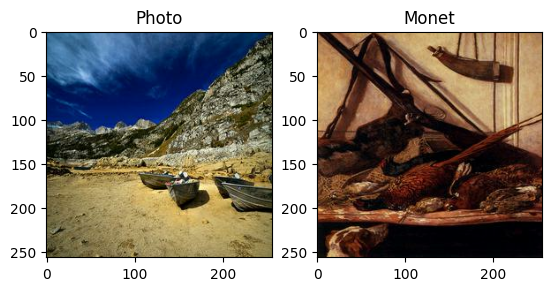

In [12]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

In [13]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

In [14]:
def upsample(filters, size, apply_dropout=False):
    
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

In [15]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

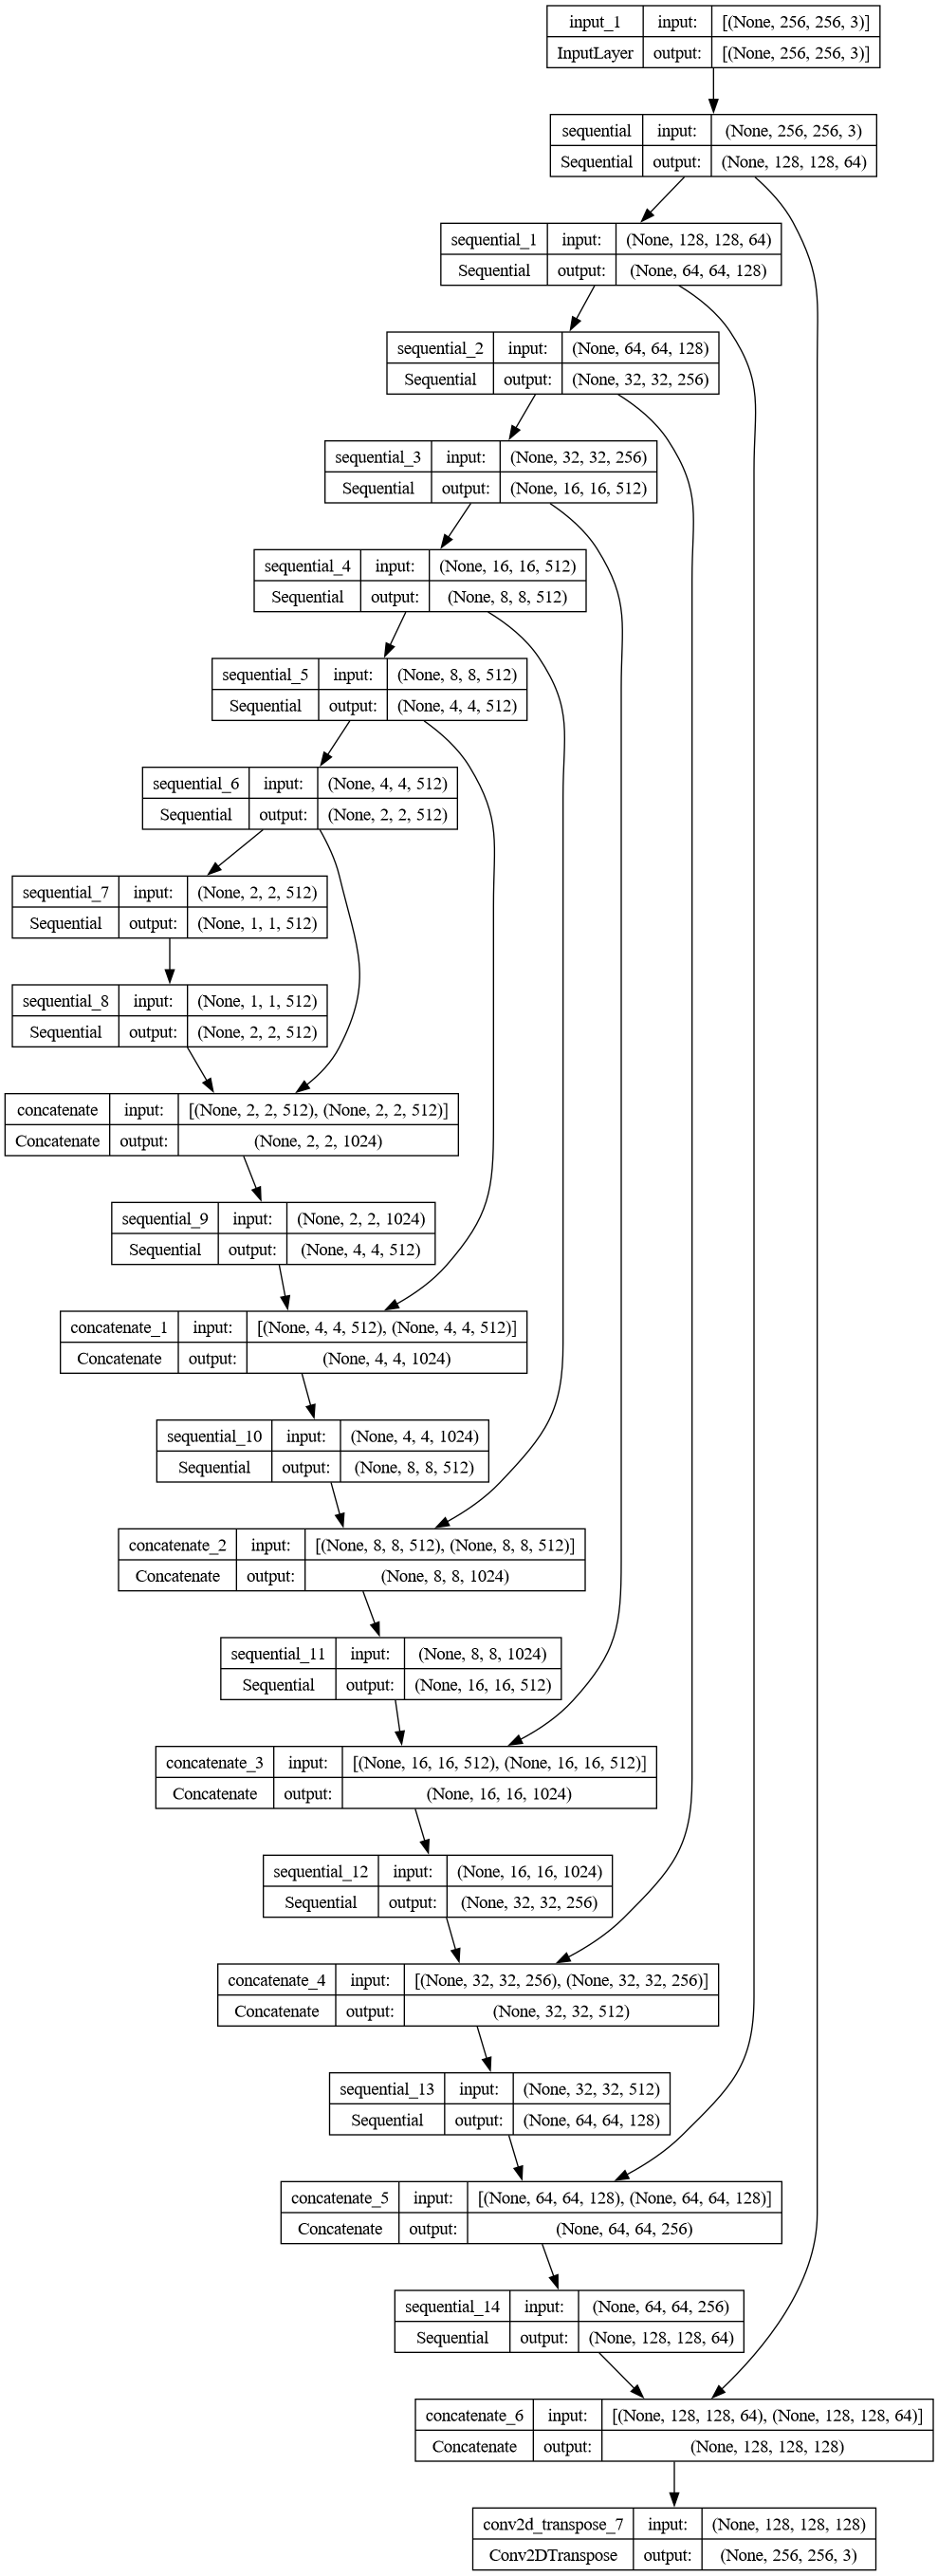

In [16]:
gen = Generator()
plot_model(gen, show_shapes=True, show_layer_names=True)

In [17]:
gen.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128, 128, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_1 (Sequential)      (None, 64, 64, 128)  131328      ['sequential[0][0]']             
                                                                                              

In [18]:
def Discriminator():

    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

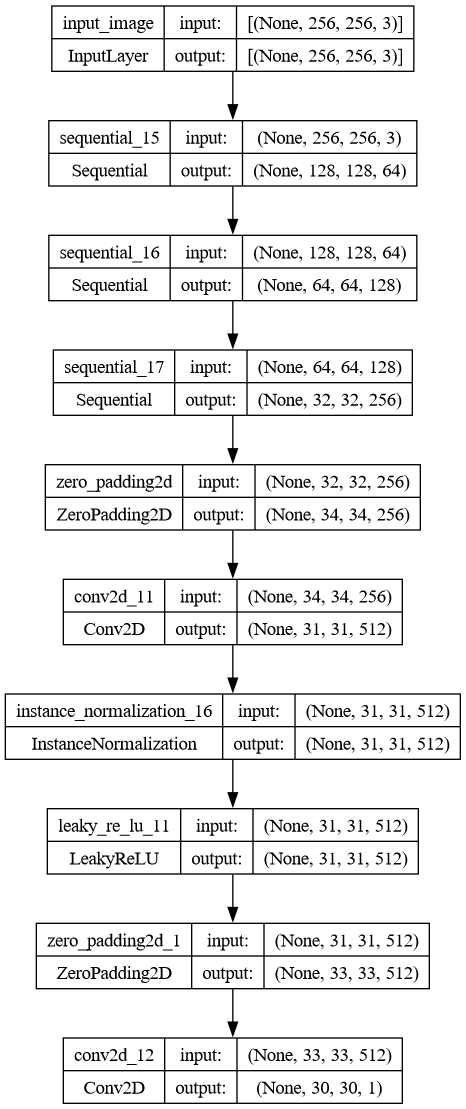

In [19]:
disc = Discriminator()
plot_model(disc, show_shapes=True, show_layer_names=True)

In [20]:
disc.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 sequential_15 (Sequential)  (None, 128, 128, 64)      3072      
                                                                 
 sequential_16 (Sequential)  (None, 64, 64, 128)       131328    
                                                                 
 sequential_17 (Sequential)  (None, 32, 32, 256)       524800    
                                                                 
 zero_padding2d (ZeroPadding  (None, 34, 34, 256)      0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 31, 31, 512)       2097152   
                                                           

In [21]:
with strategy.scope():
    
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

In [22]:
class CycleGan(keras.Model):
    
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [23]:
with strategy.scope():
    
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [24]:
with strategy.scope():
    
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, 
                                    reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated),generated)

In [25]:
#We want our original photo and the twice transformed photo to be similar to one another. 
#Thus, we can calculate the cycle consistency loss be finding the average of their difference.

with strategy.scope():
    
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [26]:
with strategy.scope():
    
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

## Training the Cycle GAN

In [27]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [28]:
with strategy.scope():
    
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [29]:
import time

class TimeCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        duration = time.time() - self.start_time
        print(f"Epoch {epoch + 1} took {duration:.2f} seconds.")

# define the callback before passing it
time_callback = TimeCallback()


In [31]:
import os
os.makedirs("training_25", exist_ok=True)

In [34]:
checkpoint_path = "training_25/cp-{epoch:02d}.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=False,
    verbose=1
)

In [35]:
history = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25,
    callbacks=[time_callback, cp_callback]
)

Epoch 1/25
300/300 [==============================] - ETA: 0s - monet_gen_loss: 3.5862 - photo_gen_loss: 3.7338 - monet_disc_loss: 0.6689 - photo_disc_loss: 0.6062Epoch 1 took 141.77 seconds.

Epoch 1: saving model to training_25\cp-01.ckpt
300/300 [==============================] - 150s 500ms/step - monet_gen_loss: 3.5861 - photo_gen_loss: 3.7326 - monet_disc_loss: 0.6689 - photo_disc_loss: 0.6064
Epoch 2/25
300/300 [==============================] - ETA: 0s - monet_gen_loss: 3.5442 - photo_gen_loss: 3.6978 - monet_disc_loss: 0.6478 - photo_disc_loss: 0.6010Epoch 2 took 149.76 seconds.

Epoch 2: saving model to training_25\cp-02.ckpt
300/300 [==============================] - 159s 529ms/step - monet_gen_loss: 3.5432 - photo_gen_loss: 3.6967 - monet_disc_loss: 0.6477 - photo_disc_loss: 0.6006
Epoch 3/25
300/300 [==============================] - ETA: 0s - monet_gen_loss: 3.4539 - photo_gen_loss: 3.6364 - monet_disc_loss: 0.6489 - photo_disc_loss: 0.6072Epoch 3 took 143.20 seconds.

Epo

In [38]:
# save only the G→M generator
monet_generator.save_weights("training_25/monet_generator_weights")

In [39]:
with strategy.scope():
    monet_generator = Generator()               # same constructor
    monet_generator.load_weights(
        "training_25/monet_generator_weights"
    )
    print("Loaded Monet generator weights.")


Loaded Monet generator weights.


In [43]:
# Right after load_weights(...)
for var in monet_generator.trainable_variables[:4]:
    print(var.name, "mean =", tf.reduce_mean(var).numpy(),
                     "std  =", tf.math.reduce_std(var).numpy())


conv2d_47/kernel:0 mean = -0.00029882 std  = 0.019793978
conv2d_48/kernel:0 mean = 3.617069e-05 std  = 0.02001035
instance_normalization_65/gamma:0 mean = -0.002068757 std  = 0.020176642
instance_normalization_65/beta:0 mean = 0.0 std  = 0.0


In [ ]:
# loaded_model = tf.keras.models.load_model("monet_generator_complete_model")
# print("Model loaded successfully for inference!")


In [41]:
# assume input_vis and output_vis are your (H,W,3) tensors
import tensorflow as tf

print("input_vis:",  input_vis.shape, input_vis.dtype,
      "min/Max →", tf.reduce_min(input_vis).numpy(), "/", tf.reduce_max(input_vis).numpy())
print("output_vis:", output_vis.shape, output_vis.dtype,
      "min/Max →", tf.reduce_min(output_vis).numpy(), "/", tf.reduce_max(output_vis).numpy())


input_vis: (256, 256, 3) <dtype: 'float32'> min/Max → 0.0 / 1.0
output_vis: (256, 256, 3) <dtype: 'float32'> min/Max → 0.45810568 / 0.5314051


In [44]:
import os

print("Contents of training_25/:", os.listdir("training_25"))


Contents of training_25/: ['checkpoint', 'cp-01.ckpt.data-00000-of-00001', 'cp-01.ckpt.index', 'cp-02.ckpt.data-00000-of-00001', 'cp-02.ckpt.index', 'cp-03.ckpt.data-00000-of-00001', 'cp-03.ckpt.index', 'cp-04.ckpt.data-00000-of-00001', 'cp-04.ckpt.index', 'cp-05.ckpt.data-00000-of-00001', 'cp-05.ckpt.index', 'cp-06.ckpt.data-00000-of-00001', 'cp-06.ckpt.index', 'cp-07.ckpt.data-00000-of-00001', 'cp-07.ckpt.index', 'cp-08.ckpt.data-00000-of-00001', 'cp-08.ckpt.index', 'cp-09.ckpt.data-00000-of-00001', 'cp-09.ckpt.index', 'cp-10.ckpt.data-00000-of-00001', 'cp-10.ckpt.index', 'cp-11.ckpt.data-00000-of-00001', 'cp-11.ckpt.index', 'cp-12.ckpt.data-00000-of-00001', 'cp-12.ckpt.index', 'cp-13.ckpt.data-00000-of-00001', 'cp-13.ckpt.index', 'cp-14.ckpt.data-00000-of-00001', 'cp-14.ckpt.index', 'cp-15.ckpt.data-00000-of-00001', 'cp-15.ckpt.index', 'cp-16.ckpt.data-00000-of-00001', 'cp-16.ckpt.index', 'cp-17.ckpt.data-00000-of-00001', 'cp-17.ckpt.index', 'cp-18.ckpt.data-00000-of-00001', 'cp-18.

In [49]:
import os
import re

# List all checkpoint prefixes of the form cp-XX.ckpt.*
files = os.listdir("training_25")
# Extract unique prefixes like 'cp-01.ckpt'
prefixes = set(re.match(r"(cp-\d{2}\.ckpt)\.", f).group(1)
               for f in files if re.match(r"cp-\d{2}\.ckpt\.", f))

# Sort and pick the last one
cp_ckpts = sorted(prefixes)
latest_full_ckpt = os.path.join("training_25", cp_ckpts[-1])
print("Manually selected full‑model checkpoint:", latest_full_ckpt)


Manually selected full‑model checkpoint: training_25\cp-25.ckpt


In [52]:
import tensorflow as tf

# 3. Rebuild & compile under your strategy
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator,
        monet_discriminator, photo_discriminator
    )
    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn     = generator_loss,
        disc_loss_fn    = discriminator_loss,
        cycle_loss_fn   = calc_cycle_loss,
        identity_loss_fn= identity_loss
    )

# 4. Load the full‑model weights
cycle_gan_model.load_weights(latest_full_ckpt)
print("✅ Restored full CycleGAN from", latest_full_ckpt)

# 5. Extract the trained Monet generator
monet_generator = cycle_gan_model.m_gen 


✅ Restored full CycleGAN from training_25\cp-25.ckpt


In [51]:
# Introspect the CycleGan object to find the generator attribute
print([attr for attr in dir(cycle_gan_model) if 'gen' in attr.lower()])


['evaluate_generator', 'fit_generator', 'gen_loss_fn', 'm_gen', 'm_gen_optimizer', 'p_gen', 'p_gen_optimizer', 'predict_generator']


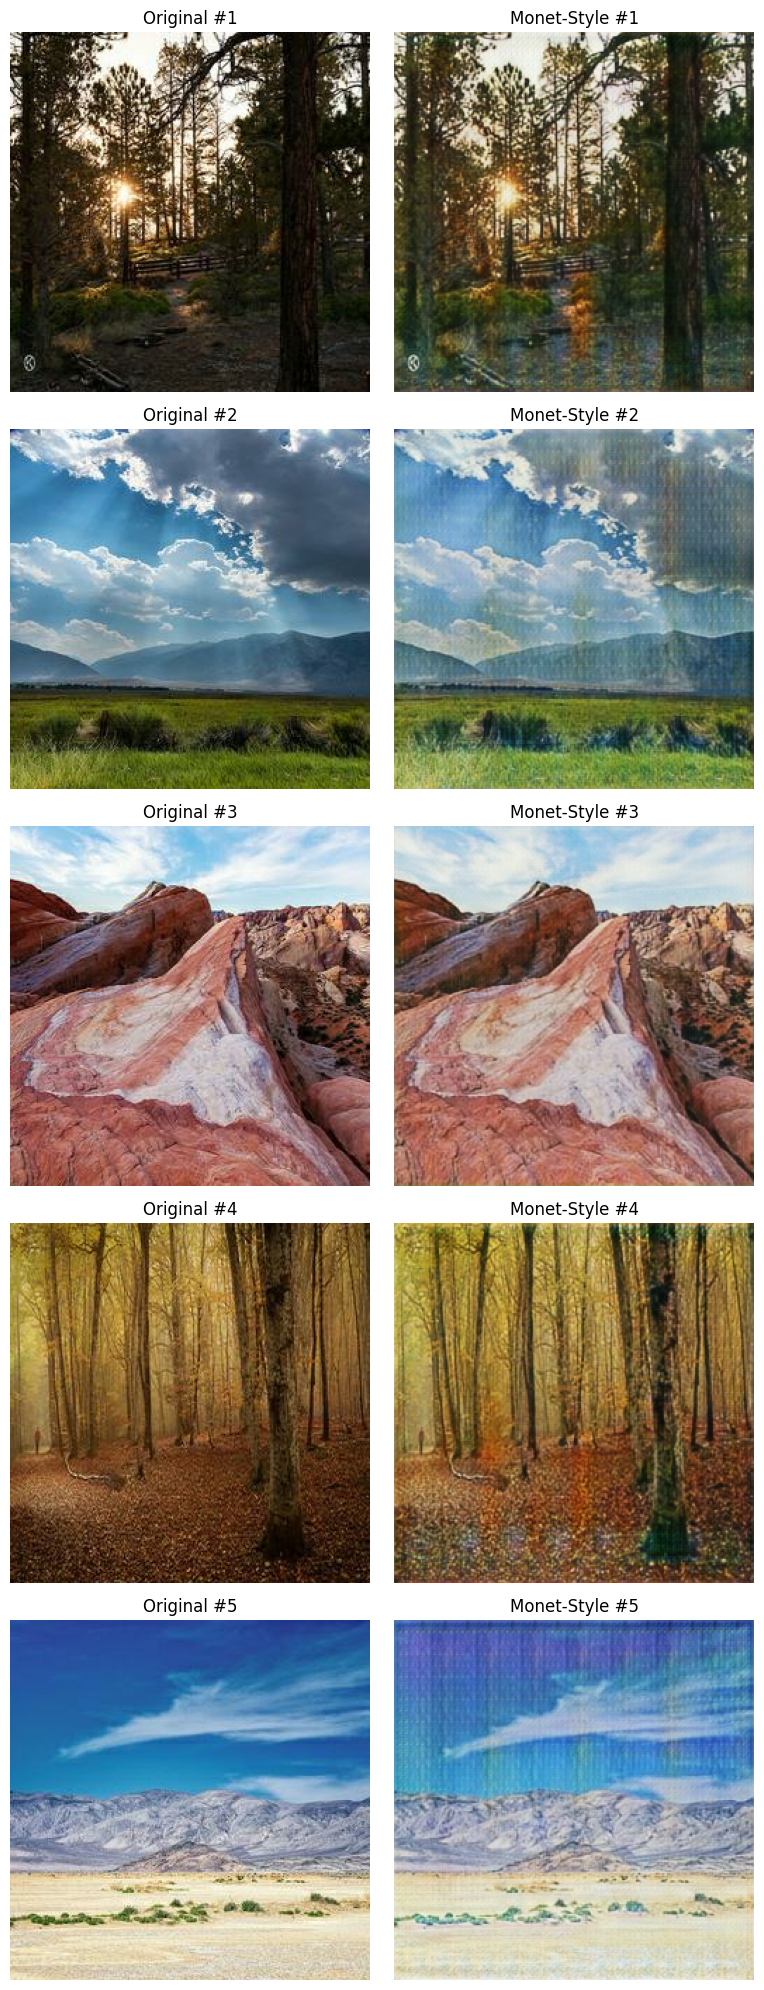

In [54]:
# Number of examples to show
num_results = 5

# Prepare a figure with 5 rows and 2 columns
fig, axes = plt.subplots(num_results, 2, figsize=(8, 4 * num_results))

for i in range(num_results):
    # 1. Pick a random image
    idx   = random.randrange(len(PHOTO_FILENAMES))
    img   = decode_image(PHOTO_FILENAMES[idx])      # [-1,1] float32, shape (H,W,3)
    batch = tf.expand_dims(img, 0)
    
    # 2. Generate Monet‑style output
    fake  = monet_generator(batch, training=False)[0]
    
    # 3. Rescale to [0,1] for display
    in_vis  = (img  + 1.0) / 2.0
    out_vis = (fake + 1.0) / 2.0
    
    # 4. Convert to NumPy & clip
    in_np  = np.clip(in_vis.numpy(),  0, 1)
    out_np = np.clip(out_vis.numpy(), 0, 1)
    
    # 5. Plot original
    ax_in  = axes[i, 0]
    ax_in.imshow(in_np)
    ax_in.axis('off')
    ax_in.set_title(f"Original #{i+1}")
    
    # 6. Plot Monet‑style
    ax_out = axes[i, 1]
    ax_out.imshow(out_np)
    ax_out.axis('off')
    ax_out.set_title(f"Monet‑Style #{i+1}")

plt.tight_layout()
plt.show()



In [55]:
monet_generator.save('monet_generator')

INFO:tensorflow:Assets written to: monet_generator\assets


INFO:tensorflow:Assets written to: monet_generator\assets


In [6]:
import os

model_path = "monet_generator"

if os.path.exists(model_path):
    print("✅ Model folder exists.")
    if "saved_model.pb" in os.listdir(model_path):
        print("✅ This is a full saved model. Ready to load with tf.keras.models.load_model().")
    else:
        print("⚠️ Folder found, but 'saved_model.pb' is missing. Might not be a full model.")
else:
    print("❌ Model folder not found.")


✅ Model folder exists.
✅ This is a full saved model. Ready to load with tf.keras.models.load_model().


In [7]:
import streamlit as st
# -------------------- CONFIG --------------------
st.set_page_config(page_title="Monet Style Transfer", layout="centered")
st.title("🎨 Monet Style Transfer using CycleGAN")
st.markdown("Upload your photo to see it reimagined in the style of Claude Monet.")

2025-05-20 23:38:30.406 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-20 23:38:30.407 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-20 23:38:30.407 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-20 23:38:30.408 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-20 23:38:30.408 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

In [8]:
# -------------------- LOAD MODEL --------------------
@st.cache_resource
def load_model():
    model = tf.keras.models.load_model("monet_generator")  # Folder path to your saved model
    return model

monet_generator = load_model()

2025-05-20 23:39:59.205 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-20 23:39:59.205 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-20 23:39:59.206 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-20 23:40:01.619 Thread 'Thread-3': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-20 23:40:01.718 Thread 'Thread-3': missing ScriptRunContext! This warning can be ignored when running in bare mode.


2025-05-20 23:40:18.779 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-20 23:40:18.781 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [9]:
# -------------------- IMAGE PREPROCESSING --------------------
def preprocess_image(img: Image.Image, target_size=(256, 256)) -> tf.Tensor:
    img = img.resize(target_size)
    img = np.array(img).astype(np.float32)
    img = (img / 127.5) - 1.0  # Normalize to [-1, 1]
    img_tensor = tf.convert_to_tensor(img)
    img_tensor = tf.expand_dims(img_tensor, 0)  # Add batch dimension
    return img_tensor

def postprocess_image(tensor: tf.Tensor) -> np.ndarray:
    img = (tensor + 1.0) / 2.0  # Rescale to [0, 1]
    img = tf.clip_by_value(img, 0.0, 1.0)
    img = img[0].numpy()
    img = (img * 255).astype(np.uint8)
    return img

In [10]:
# -------------------- UPLOAD AND INFERENCE --------------------
uploaded_file = st.file_uploader("📤 Upload a photo", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    with st.spinner("Processing image..."):
        # Load & show original image
        image = Image.open(uploaded_file).convert("RGB")
        st.image(image, caption="Original Photo", use_column_width=True)

        # Preprocess and run through model
        input_tensor = preprocess_image(image)
        output_tensor = monet_generator(input_tensor, training=False)
        output_image = postprocess_image(output_tensor)

        # Convert to PIL Image and show
        output_pil = Image.fromarray(output_image)
        st.image(output_pil, caption="🎨 Monet Style Output", use_column_width=True)

        # Download option
        img_byte_arr = io.BytesIO()
        output_pil.save(img_byte_arr, format='JPEG')
        st.download_button("📥 Download Monet Image", data=img_byte_arr.getvalue(), file_name="monet_output.jpg", mime="image/jpeg")

2025-05-20 23:41:30.031 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-20 23:41:30.032 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-20 23:41:30.032 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-20 23:41:30.033 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-20 23:41:30.033 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [11]:
# -------------------- SIDEBAR INFO --------------------
with st.sidebar:
    st.markdown("**👨‍🎨 About**")
    st.info("This app uses a pretrained CycleGAN model to turn real-world photos into Monet-style paintings.")
    st.markdown("Model trained using TensorFlow 2.x\n\nCreated by [Your Name].")

2025-05-20 23:41:44.382 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-20 23:41:44.383 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-20 23:41:44.383 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-20 23:41:44.384 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-20 23:41:44.384 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-20 23:41:44.385 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [5]:
code = """
import streamlit as st
import tensorflow as tf
from PIL import Image, ImageFilter, ImageEnhance
import numpy as np
import io

st.set_page_config(page_title="🎨 Monet Style Transfer", layout="wide")
st.markdown(
    "<h1 style='text-align: center;'>🎨 Monet Style Transfer</h1><p style='text-align: center;'>Transform your photos into beautiful Monet-style paintings</p>",
    unsafe_allow_html=True
)

# -------------------- LOAD MODEL --------------------
@st.cache_resource
def load_model():
    return tf.keras.models.load_model("monet_generator")

monet_generator = load_model()

# -------------------- IMAGE PREPROCESSING --------------------
def preprocess_image(img: Image.Image, target_size=(256, 256)) -> tf.Tensor:
    img = img.resize(target_size, Image.LANCZOS)
    arr = np.array(img).astype(np.float32)
    arr = (arr / 127.5) - 1.0
    return tf.expand_dims(arr, 0)

def postprocess_tensor(tensor: tf.Tensor) -> Image.Image:
    arr = tensor[0].numpy()
    arr = (arr + 1.0) / 2.0
    arr = np.clip(arr, 0.0, 1.0)
    arr = (arr * 255).astype(np.uint8)
    return Image.fromarray(arr)

# -------------------- SIDEBAR CONTROLS --------------------
st.sidebar.header("🛠️ Controls")

# Upload image
uploaded_file = st.sidebar.file_uploader("📤 Upload a photo", type=["jpg", "jpeg", "png"])

# Reset button
if st.sidebar.button("🔄 Reset settings"):
    st.session_state["contrast_val"] = 1.2
    st.session_state["saturation_val"] = 1.1
    st.session_state["smooth_amount"] = 0.0
    st.session_state["enhance_enabled"] = True
    st.session_state["resize_width"] = None
    st.session_state["resize_height"] = None

# Default values
contrast_val = st.sidebar.slider("Contrast", 0.5, 2.0, st.session_state.get("contrast_val", 1.2), 0.1)
saturation_val = st.sidebar.slider("Color Saturation", 0.5, 2.0, st.session_state.get("saturation_val", 1.1), 0.1)
smooth_amount = st.sidebar.slider("Smoothing", 0.0, 1.0, st.session_state.get("smooth_amount", 0.0), 0.1)

# Toggle enhancement
enhance_enabled = st.sidebar.checkbox("✨ Enable Enhancements", value=st.session_state.get("enhance_enabled", True))

# -------------------- MAIN PROCESSING --------------------
if uploaded_file:
    orig = Image.open(uploaded_file).convert("RGB")
    original_size = orig.size

    st.sidebar.markdown(f"**🖼️ Original Size:** {original_size[0]} x {original_size[1]} px")

    # Resize option
    default_width = min(original_size[0], 2048)
    resize_width = st.sidebar.number_input("New Width (optional)", min_value=64, max_value=2048, value=default_width, step=8)
    default_height = min(original_size[1], 2048)
    resize_height = st.sidebar.number_input("New Height (optional)", min_value=64, max_value=2048, value=default_height, step=8)
    target_size = (resize_width, resize_height)

    # Show processing with staged progress bar
    progress = st.progress(0, text="🧼 Preprocessing image...")

    # Resize for model
    resized_for_model = orig.resize((256, 256), Image.LANCZOS)
    progress.progress(25, text="🔄 Running style transfer...")

    inp = preprocess_image(resized_for_model)
    out_t = monet_generator(inp, training=False)
    out_img = postprocess_tensor(out_t)

    progress.progress(50, text="📐 Resizing output image...")
    out_img = out_img.resize(target_size, Image.LANCZOS)

    if enhance_enabled:
        progress.progress(65, text="✨ Applying contrast and saturation...")
        enhancer = ImageEnhance.Contrast(out_img)
        out_img = enhancer.enhance(contrast_val)
        enhancer = ImageEnhance.Color(out_img)
        out_img = enhancer.enhance(saturation_val)

        if smooth_amount > 0:
            progress.progress(80, text="🫧 Applying smoothing...")
            passes = int(smooth_amount * 5)
            for _ in range(passes):
                out_img = out_img.filter(ImageFilter.ModeFilter(size=3))

    progress.progress(100, text="✅ Done!")

    # Display
    col1, col2 = st.columns(2)
    with col1:
        st.image(orig, caption="📷 Original", use_container_width=True)
    with col2:
        st.image(out_img, caption="🖼️ Monet Style", use_container_width=True)

    # Download
    buf = io.BytesIO()
    out_img.save(buf, format="JPEG")
    st.download_button(
        "📥 Download Monet Image",
        data=buf.getvalue(),
        file_name="monet_output.jpg",
        mime="image/jpeg"
    )

# -------------------- SIDEBAR INFO --------------------
with st.sidebar:
    st.markdown("**👨‍🎨 About This App**")
    st.info("This app uses a pretrained CycleGAN generator to convert real images into Monet-style artworks. Built with 💖 using TensorFlow and Streamlit.")




"""

with open("app.py", "w", encoding='utf-8') as f:
    f.write(code)
